## Mining Complex Networks

In [1]:
# libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt

import networkx as nx
import momepy
import igraph as ig

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import collections

import math
import statistics
from scipy.stats import linregress

import warnings
warnings.filterwarnings(action="ignore")

/home/ada/anaconda3/envs/nni/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### American Grid Network

-  Perform a similar type of EDA as in Section 1.12 (in particular, replicate Table 1.1) for that graph, including getting and preparing the data (which is usually the most time consuming part of the process). 


In [2]:
# grid north america
grid_america = pd.read_csv("gridkit_north_america-highvoltage-links.csv")[[
    "wkt_srid_4326", "l_id", "v_id_1","v_id_2", "length_m"
]]
grid_america.rename(columns = {"wkt_srid_4326": "geometry", "lenght_m": "weight"}, inplace=True)
grid_america["geometry"] = grid_america.geometry.str.split(";").str[-1]

# make df a geo df
grid_america['geometry'] = grid_america['geometry'].apply(wkt.loads)
grid_america = gpd.GeoDataFrame(grid_america, geometry="geometry")

print(grid_america.shape)
grid_america.head()

(22459, 5)


,geometry,l_id,v_id_1,v_id_2,length_m
0,"LINESTRING (-99.24353 19.29064, -99.17154 19.2...",36040,13322,13394,8088.921970
1,"LINESTRING (-88.65328 33.63569, -88.35548 33.6...",10570,5366,18391,31590.935476
2,"LINESTRING (-88.24017 37.10613, -88.28262 37.0...",12952,16909,18633,3978.620211
3,"LINESTRING (-71.28148 42.12975, -71.28089 42.1...",11669,21844,21845,46.956051
4,"LINESTRING (-121.16033 38.11782, -121.14018 37...",12821,6227,22348,20368.004721


In [3]:
# line df to graph
A = momepy.gdf_to_nx(grid_america, approach='primal')

# convert networkx graph to igraph
Ai = ig.Graph.from_networkx(A) 

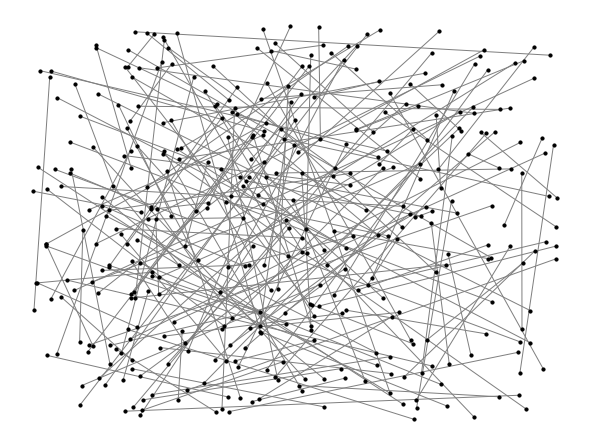

In [4]:
# visual representation of a 200-node pair sample
figure(figsize=(8, 6))
nx.draw_random(momepy.gdf_to_nx(grid_america.sample(200), approach='primal'),
               with_labels = False, node_size=10, node_color="black",
              edge_color = "gray")

In [5]:
# EDA
# no. of nodes
nodes = len(A.nodes)

# no. of edges
edges = len(A.edges)

# median degree
degrees = [i[-1] for i in nx.degree(A)]
median_degrees = statistics.median(degrees)

# 〈k〉- average degree
average_degree = statistics.mean(degrees)

# 99th quantile for the degree distribution
quant_99 = np.quantile(A, .99)

# ∆ - maximum degree
max_degree = max(degrees)

# δ - minimum degree
min_degree = min(degrees)

# diameter
diameter = Ai.diameter()

# no. of components
components = nx.number_connected_components(A)


# the largest component
L = sorted(nx.connected_components(A), key=len, reverse=True)
l = A.subgraph(L[0])
large_comp = len(l.nodes)

# no. of isolates
isolates = len([i for i in nx.isolates(A)])

# Cloc - average local clustering coefficient
cloc = Ai.transitivity_avglocal_undirected()

# Cglob  - global clustering coefficient
cglob = Ai.transitivity_undirected()


In [6]:
# eda df
eda_df = pd.DataFrame(index = [
    "# nodes", "# edges", "δ", "〈k〉", "median degree", "dquant99",
    "∆", "diameter", "# components", "the largest component", "# isolates",
    "Cglob", "Cloc"
], columns = ["North America Grid"])
eda_df["North America Grid"] = [nodes, edges, min_degree, average_degree,
                                median_degrees, quant_99, max_degree, diameter, 
                                components, large_comp, isolates, cglob, cloc
                               ]
eda_df

,North America Grid
# nodes,16167.000000
# edges,22459.000000
δ,1.000000
〈k〉,2.778376
median degree,3.000000
dquant99,49.869937
∆,27.000000
diameter,138.000000
# components,34.000000
the largest component,14990.000000


### GitHub (ml) graph


- Consider the GitHub (ml) graph on 9,739 nodes.


In [7]:
# read the target and edges df then merge and subset to ml
target = pd.read_csv("musae_git_target.csv")
edges = pd.read_csv("musae_git_edges.csv")

# subset to ml
target = target.loc[target.ml_target == 1]
ml_devs = target.id.values

# subset based on ml_devs list
edges = edges.loc[
    (edges.id_1.isin(ml_devs)) & (edges.id_2.isin(ml_devs))
]
print(edges.shape)
edges.head()

(19684, 2)


,id_1,id_2
10,6067,20183
17,4,9342
347,32,4293
348,32,22351
350,33,5398


In [8]:
# create graph
G = nx.Graph()
G.add_nodes_from(ml_devs)
G.add_edges_from(edges[["id_1", "id_2"]].values.tolist())
# edges and nodes
len(G.edges), len(G.nodes)

(19684, 9739)

1. Find the number of walks of length 5.

In [9]:
def findPaths(G,u,n,excludeSet = None):
    if excludeSet == None:
        excludeSet = set([u])
    else:
        excludeSet.add(u)
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) if neighbor not in excludeSet for path in findPaths(G,neighbor,n-1,excludeSet)]
    excludeSet.remove(u)
    return paths


In [10]:
walks = []
for node in G:
    walks.extend(findPaths(G,node, 5))
    
print("Number of walks of length 5 = ", len(walks))

Number of walks of length 5 =  8929418


2. Find the number of cycles of length 4 (induced, that is, without chords).

In [11]:
print("Number of cycles of length 4 = ", len(nx.cycle_basis(G, 4)))

Number of cycles of length 4 =  12411


### Airport Graph

- Consider the airport graph.
- This graph is weighted and directed; the weight of a directed edge uv corresponds to the number of passengers travelling from airport u to airport v.

In [12]:
airports = pd.read_csv("Airports2.csv")
print(airports.shape)
airports.rename(columns = {"Passengers": "weight"}, inplace=True)
airports.head()

(3606803, 15)


,Origin_airport,Destination_airport,Origin_city,Destination_city,weight,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [13]:
G = nx.from_pandas_edgelist(
    airports, 
    source= "Origin_airport", 
    target = "Destination_airport",
    edge_attr = ["weight"]
)
G = G.to_directed()
nx.is_directed(G)

True


1. Plot the cumulative degree distribution (points (l, n≥l), where
n≥l is the number of nodes of degree at least (l ≥ 1) in the
log-log plot. Find the slope of the line obtained via linear regression.


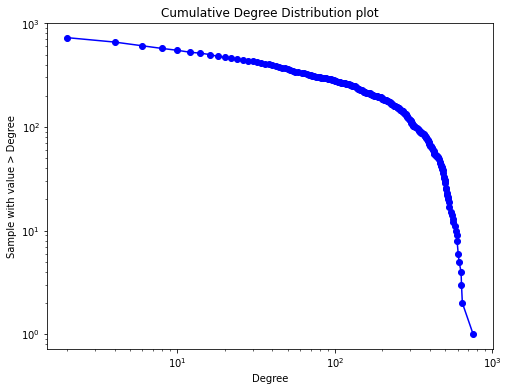

Slope =  -0.8648827771740163


In [14]:
# the degree method sums both the in and out degree for directed graphs
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

figure(figsize=(8, 6))
plt.loglog(deg, cs, linestyle='-', marker='o', color='b',)
plt.title("Cumulative Degree Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

# slope via linear regression
res = linregress(np.log10(deg), np.log10(cs))
print("Slope = ", res[0])

2. Find the busiest airport. In other words, find the node with
the maximum total degree (degin(v) + degout(v)).

In [15]:
indegree_max  = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
outdegree_max = sorted(G.out_degree, key=lambda x: x[1], reverse=True)

degree_df = pd.DataFrame(indegree_max, columns = ["node", "in_degree"])
d = pd.DataFrame(outdegree_max, columns = ["nodes", "out_degree"])
degree_df = pd.concat([degree_df, d], axis=1)[["node", "in_degree", "out_degree"]]
degree_df["degrees"] = degree_df["in_degree"] + degree_df["out_degree"]
degree_df.sort_values(by = "degrees", ascending=False)
degree_df.head(1)

,node,in_degree,out_degree,degrees
0,YIP,377,377,754


YIP is the busiest airport with a maximum total degree of 754.

3. Find the number of strongly connected components.


In [16]:
strongly_connected_components = [i for i in nx.strongly_connected_components(G)]
print("The number of strongly_connected_components is = ", len(strongly_connected_components[0]))

The number of strongly_connected_components is =  727


4. Find the subgraph induced by all airports from California.
Find the number of isolated nodes in this subgraph

In [17]:
# get a list of california airports == nodes
from_ = airports[
    ["Origin_airport", "Destination_airport", "Origin_city", "Destination_city", "weight"]
    ][airports["Origin_city"].str.contains("CA")]

to_ = airports[
    ["Origin_airport", "Destination_airport", "Origin_city", "Destination_city", "weight"]
    ][airports["Destination_airport"].str.contains("CA")]

california = pd.concat([from_, to_]).drop_duplicates()
origin_codes = california.Origin_airport.unique()
destination_codes = california.Destination_airport.unique()
california_codes = np.concatenate((origin_codes, destination_codes))
california_codes = np.unique(california_codes)
len(california_codes)

386

In [18]:
# induced california subgraph
C = nx.induced_subgraph(G, list(california_codes))

# isolated nodes
[i for i in nx.isolates(C)]

[]

The California induced subgraph has 0 isolated nodes.

### European Grid network

- Undirected data of power grids.
- Take 100 random pairs of nodes in the European Grid network. 
- For each pair plot a point (x, y), where x is the graph distance between the two nodes and y is the corresponding geographical distance (in kilometres). 

In [19]:
# grid lines df: express as a geo dataframe
grid2 = pd.read_csv("gridkit_europe-highvoltage-links.csv")
grid2["geometry"] = grid2["wkt_srid_4326"]
# grid2.rename(columns = {"wkt_srid_4326": "geometry"}, inplace=True)
grid2 = grid2[["v_id_1", "v_id_2", "geometry", "wkt_srid_4326"]]
grid2["geometry"] = grid2.geometry.str.split(";").str[-1]
grid2["wkt_srid_4326"] = grid2.wkt_srid_4326.str.split(";").str[-1]
grid2['geometry'] = grid2['geometry'].apply(wkt.loads)
grid2 = gpd.GeoDataFrame(grid2, geometry="geometry")

# sample 100 random pairs of nodes
grid2 = grid2.sample(100)

# change geodf crs to get distance in m
grid2.set_crs(epsg=3857, inplace=True)

# calculate geographic distance:
grid2["geo_distance"] = (grid2.geometry.length)/1000

print(grid2.shape)
grid2.head()

(100, 5)


,v_id_1,v_id_2,geometry,wkt_srid_4326,geo_distance
18682,28309,25931,"LINESTRING (-2.17204 53.71957, -2.29940 53.78788)","LINESTRING(-2.17204470014168 53.7195670768529,...",0.000145
4316,53236,55608,"LINESTRING (38.36404 48.52578, 38.28223 48.45337)","LINESTRING(38.3640385844996 48.5257842858302,3...",0.000109
17258,32511,66522,"LINESTRING (28.13875 60.85771, 28.13254 60.86038)","LINESTRING(28.1387541182435 60.85770527586,28....",0.000007
18713,5053,67991,"LINESTRING (6.99648 49.37541, 6.79704 49.33545)","LINESTRING(6.99647662277982 49.3754093214106,6...",0.000203
3483,22396,20408,"LINESTRING (1.76930 48.95195, 1.75788 48.97093)","LINESTRING(1.76929788841525 48.9519521022809,1...",0.000022


In [20]:
# graph representation
graph = momepy.gdf_to_nx(grid2, approach='primal')

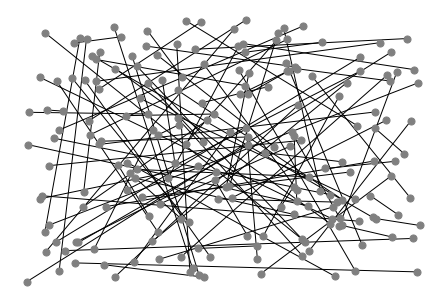

In [21]:
nx.draw_random(graph, with_labels = False, node_size=50, node_color="gray")

In [22]:
# graph distance calculation
for n in graph.nodes:
    graph.nodes[n]['coords'] = np.random.rand(2)
    
def get_graph_distance(graph, node1, node2):
    x1, y1 = graph.nodes[node1]['coords']
    x2, y2 = graph.nodes[node2]['coords']
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) 


graph_distance = {}

for i in graph.edges:
    graph_distance[i[:2]] = get_graph_distance(graph, i[0], i[1])
    
    
len(graph_distance)

100

In [23]:
# graph distances df: euclidean
graph_dist_df = pd.DataFrame(graph_distance.keys(), columns=["lat", "lon"])
graph_dist_df["graph_dist"] = graph_distance.values()
graph_dist_df["point"] = "LINESTRING" + graph_dist_df.lat.astype(str) + " " + graph_dist_df.lon.astype(str)
graph_dist_df["point"] = graph_dist_df["point"].str.replace(",", "")
graph_dist_df.drop(["lat", "lon"], axis=1, inplace=True)
graph_dist_df.head()

# geo dist df
geo_dist_df = grid2[["wkt_srid_4326", "geo_distance"]]
geo_dist_df["wkt_srid_4326"] = geo_dist_df["wkt_srid_4326"].str.replace(",", ") (")
geo_dist_df.head()

# dist df
dist_df = pd.merge(
    graph_dist_df, geo_dist_df, left_on = "point", right_on = "wkt_srid_4326", how="outer")
print(dist_df.shape)
dist_df.head()

(100, 4)


,graph_dist,point,wkt_srid_4326,geo_distance
0,0.776447,LINESTRING(-2.17204470014168 53.7195670768529)...,LINESTRING(-2.17204470014168 53.7195670768529)...,0.000145
1,0.616933,LINESTRING(38.3640385844996 48.5257842858302) ...,LINESTRING(38.3640385844996 48.5257842858302) ...,0.000109
2,0.569577,LINESTRING(28.1387541182435 60.85770527586) (2...,LINESTRING(28.1387541182435 60.85770527586) (2...,0.000007
3,0.928056,LINESTRING(6.99647662277982 49.3754093214106) ...,LINESTRING(6.99647662277982 49.3754093214106) ...,0.000203
4,0.539219,LINESTRING(1.76929788841525 48.9519521022809) ...,LINESTRING(1.76929788841525 48.9519521022809) ...,0.000022


1. Is there a correlation between the two distances? In order to compute the geographical distance you may, for example, use function geodesic from geopy package or implement it from scratch using the haversine formula that determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [24]:
# correlation
np.corrcoef(dist_df.graph_dist, dist_df.geo_distance)

array([[1.        , 0.05582327],
       [0.05582327, 1.        ]])

No significant correlation (=0.101) is observed between the 2 distances.